In [1]:
#!pip install albumentations

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

#!pip install -q segmentation-models-pytorch
#!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

#print(os.getenv('PATH'))
print(torch.cuda.is_available())

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

True


device(type='cuda')

In [3]:
from pathlib import Path

# For local file paths (Windows)
data_directory = Path(r'C:\Users\GeoFly\Documents\rfan\Seagrass\image\WA_Non_Zero')

IMAGE_PATH = data_directory / "image"
MASK_PATH = data_directory / "index"

print("image_path:", IMAGE_PATH)



image_path: C:\Users\GeoFly\Documents\rfan\Seagrass\image\WA_Non_Zero\image


In [4]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision not available.")

torch version: 2.1.1+cu118
torchvision version: 0.16.1+cpu


In [5]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should return the current GPU device
print(torch.cuda.get_device_name(0))  # Should return the name of the GPU


True
0
NVIDIA GeForce RTX 4090


In [6]:
n_classes = 2 # classes of the mask

def create_dataframe():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id':name}, index= np.arange(0, len(name)))

df = create_dataframe()

df

,id
0,BH_19_tile_100
1,BH_19_tile_101
2,BH_19_tile_102
3,BH_19_tile_103
4,BH_19_tile_115
...,...
2410,NC_21_tile_67
2411,NC_21_tile_68
2412,NC_21_tile_89
2413,NC_21_tile_92


In [7]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

Image Path: C:\Users\GeoFly\Documents\rfan\Seagrass\image\WA_Non_Zero\image\FB_19_tile_361.png
Mask Path: C:\Users\GeoFly\Documents\rfan\Seagrass\image\WA_Non_Zero\index\FB_19_tile_361.png


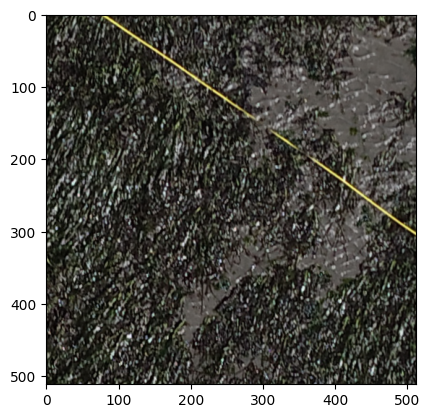

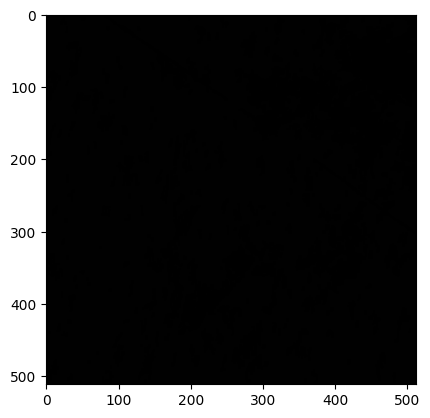

(512, 512, 3)
(512, 512, 3)


In [8]:
for idx in X_val:
    img_path = os.path.join(IMAGE_PATH, idx + '.png')
    mask_path = os.path.join(MASK_PATH, idx + '.png')

    
    # Print out the file paths for debugging
    print("Image Path:", img_path)
    print("Mask Path:", mask_path)
    
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    plt.imshow(img)
    plt.show()
    plt.imshow(mask)
    plt.show()
    print(np.asarray(img).shape)
    print(np.asarray(mask).shape)
    break

In [9]:
class Drone_data(Dataset):
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patch = patch

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Create image and mask paths using pathlib
        img_path = self.img_path / f'{self.X[idx]}.png'
        mask_path = self.mask_path / f'{self.X[idx]}.png'
        
        # Read and convert the image to RGB
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Open and convert the mask to grayscale
        mask = Image.open(mask_path)
        mask = mask.convert("L")
        #img = cv2.imread(self.img_path + self.X[idx] + '.png')
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        #mask = Image.open(self.mask_path + self.X[idx] + '.png')
        #mask = mask.convert("L")  # Convert mask to grayscale

        if self.transform is not None:
            aug = self.transform(image=img, mask=np.array(mask))  # Convert mask to NumPy array
            img = aug['image']
            mask = aug['mask']

        # Convert to tensors
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(np.array(mask)).long()

        if self.patch:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):
        # Implementation of tile extraction if needed
        pass


In [10]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = Drone_data(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = Drone_data(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 8

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [11]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=2, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [12]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [13]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [14]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [15]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            #output = torch.argmax(output, dim=1)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    
    total_time_minutes = (time.time() - fit_time) / 60

    # Print the total time
    print('Total time: {:.2f} m'.format(total_time_minutes))

    #print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [16]:
torch.cuda.empty_cache()

In [17]:
import subprocess

def check_gpu_memory():
    result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
    print(result.stdout.decode('utf-8'))

check_gpu_memory()

Wed May  1 18:23:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.12                 Driver Version: 552.12         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  |   00000000:01:00.0  On |                  Off |
|  0%   32C    P8             12W /  450W |     728MiB /  24564MiB |     22%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [18]:
max_lr = 1e-4
epoch = 100
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.719 
Epoch:1/100.. Train Loss: 0.817.. Val Loss: 0.719.. Train mIoU:0.351.. Val mIoU: 0.401.. Train Acc:0.522.. Val Acc:0.579.. Time: 5.02m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.719 >> 0.618 
Epoch:2/100.. Train Loss: 0.682.. Val Loss: 0.618.. Train mIoU:0.454.. Val mIoU: 0.521.. Train Acc:0.633.. Val Acc:0.707.. Time: 4.66m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.618 >> 0.580 
Epoch:3/100.. Train Loss: 0.632.. Val Loss: 0.580.. Train mIoU:0.511.. Val mIoU: 0.585.. Train Acc:0.693.. Val Acc:0.760.. Time: 4.76m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.580 >> 0.510 
saving model...
Epoch:4/100.. Train Loss: 0.580.. Val Loss: 0.510.. Train mIoU:0.549.. Val mIoU: 0.607.. Train Acc:0.724.. Val Acc:0.781.. Time: 4.74m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.510 >> 0.490 
Epoch:5/100.. Train Loss: 0.539.. Val Loss: 0.490.. Train mIoU:0.574.. Val mIoU: 0.609.. Train Acc:0.742.. Val Acc:0.777.. Time: 4.66m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.490 >> 0.443 
Epoch:6/100.. Train Loss: 0.510.. Val Loss: 0.443.. Train mIoU:0.588.. Val mIoU: 0.629.. Train Acc:0.752.. Val Acc:0.801.. Time: 4.56m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.443 >> 0.417 
Epoch:7/100.. Train Loss: 0.492.. Val Loss: 0.417.. Train mIoU:0.597.. Val mIoU: 0.652.. Train Acc:0.760.. Val Acc:0.804.. Time: 4.72m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.417 >> 0.396 
Epoch:8/100.. Train Loss: 0.484.. Val Loss: 0.396.. Train mIoU:0.601.. Val mIoU: 0.665.. Train Acc:0.764.. Val Acc:0.820.. Time: 4.71m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.396 >> 0.392 
saving model...
Epoch:9/100.. Train Loss: 0.470.. Val Loss: 0.392.. Train mIoU:0.610.. Val mIoU: 0.655.. Train Acc:0.770.. Val Acc:0.813.. Time: 4.70m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.392 >> 0.391 
Epoch:10/100.. Train Loss: 0.461.. Val Loss: 0.391.. Train mIoU:0.622.. Val mIoU: 0.662.. Train Acc:0.779.. Val Acc:0.816.. Time: 4.50m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.391 >> 0.381 
Epoch:11/100.. Train Loss: 0.459.. Val Loss: 0.381.. Train mIoU:0.618.. Val mIoU: 0.667.. Train Acc:0.778.. Val Acc:0.828.. Time: 4.63m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.381 >> 0.377 
Epoch:12/100.. Train Loss: 0.444.. Val Loss: 0.377.. Train mIoU:0.630.. Val mIoU: 0.685.. Train Acc:0.787.. Val Acc:0.825.. Time: 4.68m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.377 >> 0.375 
Epoch:13/100.. Train Loss: 0.438.. Val Loss: 0.375.. Train mIoU:0.638.. Val mIoU: 0.678.. Train Acc:0.793.. Val Acc:0.824.. Time: 4.78m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.375 >> 0.361 
saving model...
Epoch:14/100.. Train Loss: 0.424.. Val Loss: 0.361.. Train mIoU:0.650.. Val mIoU: 0.685.. Train Acc:0.802.. Val Acc:0.840.. Time: 4.69m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:15/100.. Train Loss: 0.420.. Val Loss: 0.363.. Train mIoU:0.650.. Val mIoU: 0.688.. Train Acc:0.803.. Val Acc:0.839.. Time: 4.49m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.363 >> 0.346 
Epoch:16/100.. Train Loss: 0.410.. Val Loss: 0.346.. Train mIoU:0.659.. Val mIoU: 0.708.. Train Acc:0.810.. Val Acc:0.850.. Time: 4.59m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:17/100.. Train Loss: 0.405.. Val Loss: 0.348.. Train mIoU:0.665.. Val mIoU: 0.698.. Train Acc:0.814.. Val Acc:0.844.. Time: 4.45m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.348 >> 0.347 
Epoch:18/100.. Train Loss: 0.401.. Val Loss: 0.347.. Train mIoU:0.668.. Val mIoU: 0.715.. Train Acc:0.816.. Val Acc:0.855.. Time: 4.32m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.347 >> 0.346 
Epoch:19/100.. Train Loss: 0.401.. Val Loss: 0.346.. Train mIoU:0.665.. Val mIoU: 0.699.. Train Acc:0.815.. Val Acc:0.850.. Time: 4.19m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.346 >> 0.335 
Epoch:20/100.. Train Loss: 0.387.. Val Loss: 0.335.. Train mIoU:0.679.. Val mIoU: 0.718.. Train Acc:0.825.. Val Acc:0.855.. Time: 4.27m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.335 >> 0.324 
saving model...
Epoch:21/100.. Train Loss: 0.385.. Val Loss: 0.324.. Train mIoU:0.677.. Val mIoU: 0.730.. Train Acc:0.824.. Val Acc:0.862.. Time: 4.23m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:22/100.. Train Loss: 0.385.. Val Loss: 0.330.. Train mIoU:0.676.. Val mIoU: 0.729.. Train Acc:0.824.. Val Acc:0.859.. Time: 4.27m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.330 >> 0.327 
Epoch:23/100.. Train Loss: 0.385.. Val Loss: 0.327.. Train mIoU:0.679.. Val mIoU: 0.722.. Train Acc:0.825.. Val Acc:0.860.. Time: 4.18m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.327 >> 0.317 
Epoch:24/100.. Train Loss: 0.371.. Val Loss: 0.317.. Train mIoU:0.693.. Val mIoU: 0.729.. Train Acc:0.834.. Val Acc:0.864.. Time: 4.25m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:25/100.. Train Loss: 0.365.. Val Loss: 0.326.. Train mIoU:0.695.. Val mIoU: 0.731.. Train Acc:0.836.. Val Acc:0.860.. Time: 4.14m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.326 >> 0.323 
Epoch:26/100.. Train Loss: 0.358.. Val Loss: 0.323.. Train mIoU:0.699.. Val mIoU: 0.736.. Train Acc:0.838.. Val Acc:0.862.. Time: 4.22m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:27/100.. Train Loss: 0.367.. Val Loss: 0.326.. Train mIoU:0.696.. Val mIoU: 0.728.. Train Acc:0.837.. Val Acc:0.860.. Time: 4.24m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:28/100.. Train Loss: 0.367.. Val Loss: 0.331.. Train mIoU:0.692.. Val mIoU: 0.728.. Train Acc:0.836.. Val Acc:0.858.. Time: 4.19m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.331 >> 0.313 
Epoch:29/100.. Train Loss: 0.355.. Val Loss: 0.313.. Train mIoU:0.703.. Val mIoU: 0.726.. Train Acc:0.842.. Val Acc:0.861.. Time: 4.20m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.313 >> 0.313 
saving model...
Epoch:30/100.. Train Loss: 0.359.. Val Loss: 0.313.. Train mIoU:0.698.. Val mIoU: 0.737.. Train Acc:0.839.. Val Acc:0.868.. Time: 4.18m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Decreasing.. 0.313 >> 0.309 
Epoch:31/100.. Train Loss: 0.355.. Val Loss: 0.309.. Train mIoU:0.702.. Val mIoU: 0.733.. Train Acc:0.841.. Val Acc:0.866.. Time: 4.35m


  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 143.01 m


In [19]:
torch.save(model, 'Unet-mobilenet2-batchsize8-WA_NON_ZERO_lr-4.pt')

In [20]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

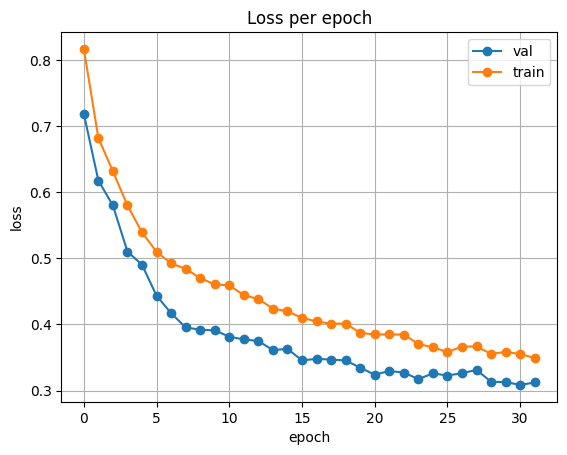

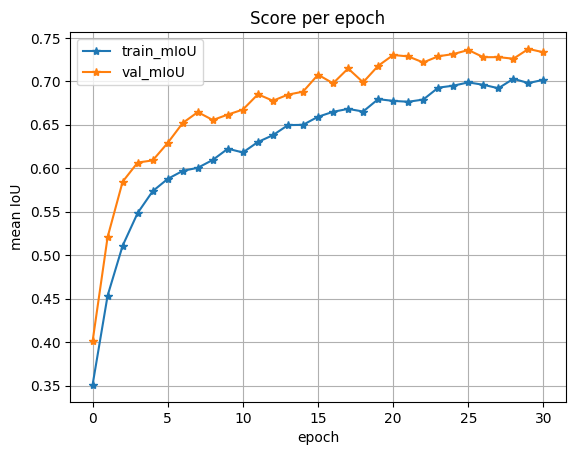

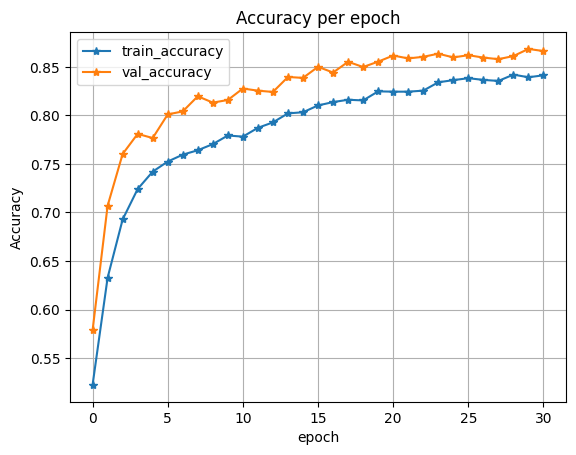

In [21]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [22]:
import torchvision.transforms as transforms

def to_tensor(image):
    return transforms.ToTensor()(image)

In [23]:
class DroneTestDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = Path(img_path)
        self.mask_path = Path(mask_path)
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Create image and mask paths using pathlib
        img_path = self.img_path / f'{self.X[idx]}.png'
        mask_path = self.mask_path / f'{self.X[idx]}.png'
        
        # Read and convert the image to RGB using OpenCV
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Read the mask in grayscale directly using OpenCV
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            # Convert image and mask to NumPy arrays for transformation
            # Note: Assuming self.transform can handle NumPy arrays directly
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        
        # Convert the image to PIL Image (consistent with DroneTestDataset1)
        img = Image.fromarray(img)

        # Convert mask to a PyTorch tensor
        mask = torch.from_numpy(mask).long()

        return img, mask

t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [24]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [25]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [26]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [27]:
mob_miou = miou_score(model, test_set)
mob_miou

  0%|          | 0/242 [00:00<?, ?it/s]

[0.4364726809840694,
 0.8890781567075738,
 0.5061884992727519,
 0.5326024099671807,
 0.772325230547888,
 0.4561507739900358,
 0.42888398650154447,
 0.8183346275046357,
 0.5941431835466975,
 0.5918510088743275,
 0.7398145775823386,
 0.5596045986501345,
 0.4435165464139503,
 0.41838863465778,
 0.6840615097515341,
 0.4433680276140476,
 0.5527654080837826,
 0.9333695668056105,
 0.4296723764448037,
 0.5902841170531673,
 0.4940720745082624,
 0.5100660669987096,
 0.5973878373144841,
 0.8185716223831232,
 0.4976654729496781,
 0.729504690461722,
 0.26404091163917837,
 0.550213382056195,
 0.4476507006273571,
 0.7591139523272741,
 0.7911717868570625,
 0.5523802944896508,
 0.4983384874132114,
 0.4993489583333767,
 0.4969098126446851,
 0.42440509292528544,
 0.4749755859375011,
 0.41103590416546454,
 0.4904005262586835,
 0.8432722934907697,
 0.3832846580512497,
 0.5120099477207849,
 0.3968484607690166,
 0.49821641710071024,
 0.5264106227238737,
 0.44322371412656447,
 0.2323874014395256,
 0.873470825

In [28]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [29]:
mob_acc = pixel_acc(model, test_set)
mob_acc

  0%|          | 0/242 [00:00<?, ?it/s]

[0.7896660698784722,
 0.9722674334490741,
 0.9679475007233797,
 0.8620119448061343,
 0.8928019205729166,
 0.9003442834924769,
 0.6155598958333334,
 0.9170012297453703,
 0.9444975676359953,
 0.9467716923466435,
 0.8626550745081019,
 0.9322215892650463,
 0.7359415690104166,
 0.7978832103587963,
 0.8624663176359953,
 0.6883567527488426,
 0.8162073206018519,
 0.9665199562355324,
 0.8575676812065972,
 0.9568458839699074,
 0.9870944552951388,
 0.7355244954427084,
 0.9633382161458334,
 0.9172871907552084,
 0.9948888708043981,
 0.8970269097222222,
 0.5280818232783565,
 0.9232878508391203,
 0.8542864764178241,
 0.8648715549045138,
 0.9317140932436343,
 0.9849209255642362,
 0.9966769748263888,
 0.9986979166666666,
 0.9938196252893519,
 0.7025575991030093,
 0.949951171875,
 0.8220226146556713,
 0.9808010525173612,
 0.93548583984375,
 0.5626186794704862,
 0.9841591163917824,
 0.7165889033564815,
 0.9964328342013888,
 0.7027169686776621,
 0.8814177336516203,
 0.46477480287905093,
 0.973789921513310

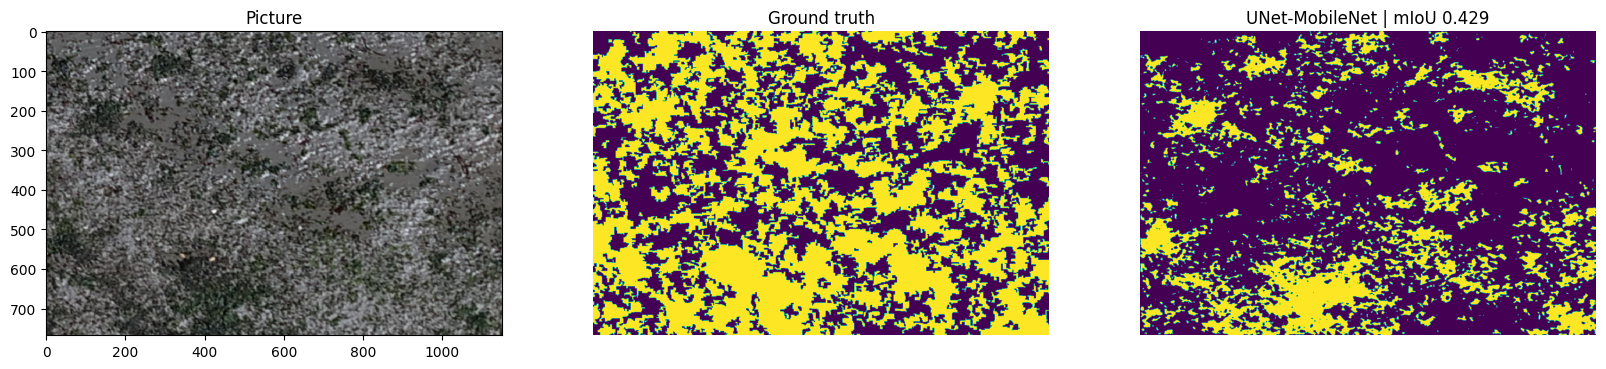

In [30]:
image, mask = test_set[6]
pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
# Convert torch tensor to numpy array and transpose if necessary

ax1.imshow(image)
ax1.set_title('Picture')

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

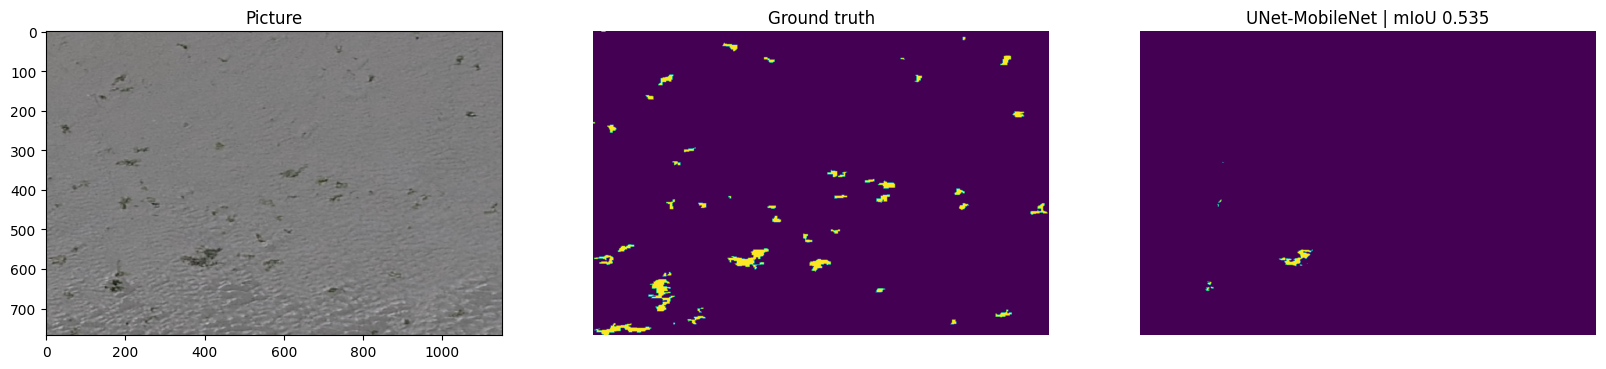

In [31]:
image2, mask2 = test_set[93]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

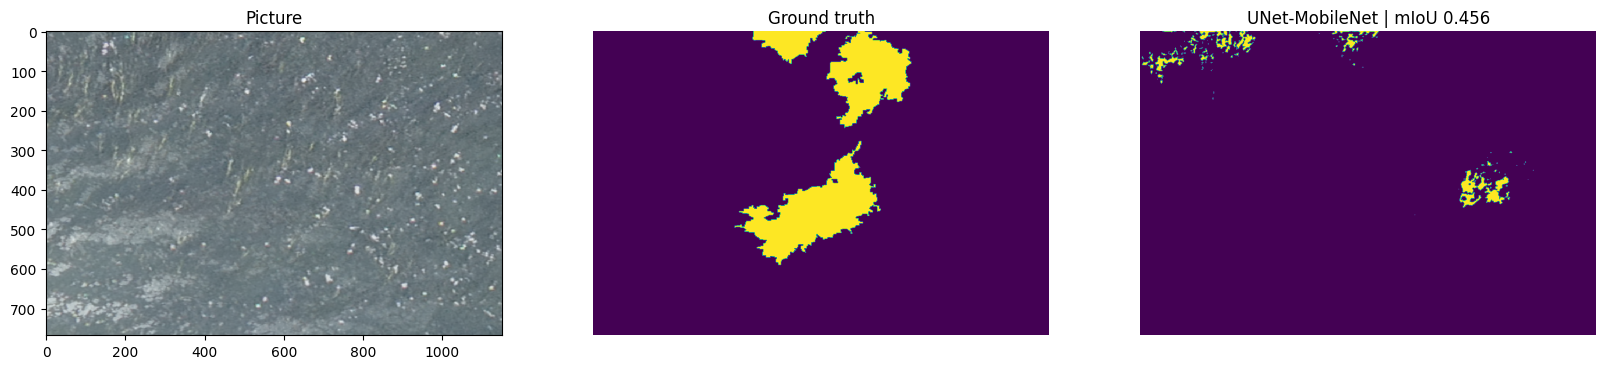

In [32]:
image3, mask3 = test_set[5]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [33]:
image4, mask4 = test_set[490]
pred_mask4, score4 = predict_image_mask_miou(model, image4, mask4)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image4)
ax1.set_title('Picture');

ax2.imshow(mask4)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask4)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

IndexError: index 490 is out of bounds for axis 0 with size 242

In [ ]:
print('Test Set mIoU', np.mean(mob_miou))

In [ ]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))